<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/dl-time-series-forecasting/blob/main/Multivariat_VAR_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Soedirman-Machine-Learning/dl-time-series-forecasting

Cloning into 'dl-time-series-forecasting'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 42 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from pandas import read_csv

df = pd.read_csv('https://raw.githubusercontent.com/Soedirman-Machine-Learning/dl-time-series-forecasting/main/dataset.csv')

print(df.shape)
df.tail()


(2394, 8)


,u1,u2,u3,u4,u5,u6,u7,y
2389,0.284859,0.645894,0.688723,0.355109,0.615583,0.608848,0.500866,0.188976
2390,0.266139,0.665503,0.665640,0.354275,0.588834,0.582074,0.508999,0.178992
2391,0.247419,0.665706,0.664740,0.353441,0.561301,0.602186,0.523348,0.169742
2392,0.228699,0.672975,0.677300,0.352607,0.530730,0.636970,0.537697,0.159023
2393,0.215821,0.668945,0.677877,0.351774,0.500161,0.684994,0.569601,0.149922


In [4]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,u1_x,u2_x,u3_x,u4_x,u5_x,u6_x,u7_x,y_x
u1_y,1.0,0.0001,0.0,0.0001,0.0000,0.0000,0.0000,0.0000
u2_y,0.0,1.0000,0.0,0.4507,0.0002,0.0213,0.0117,0.0012
u3_y,0.0,0.0000,1.0,0.0000,0.0000,0.0000,0.0000,0.0631
u4_y,0.0,0.0000,0.0,1.0000,0.0049,0.0002,0.0015,0.2333
u5_y,0.0,0.0000,0.0,0.0002,1.0000,0.0000,0.0000,0.0000
u6_y,0.0,0.0000,0.0,0.0000,0.0000,1.0000,0.0000,0.0006
u7_y,0.0,0.0000,0.0,0.0000,0.0000,0.0000,1.0000,0.0000
y_y,0.0,0.0000,0.0,0.0406,0.0000,0.0000,0.0000,1.0000


In [5]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
u1     ::  542.53    > 143.6691  =>   True
u2     ::  312.81    > 111.7797  =>   True
u3     ::  210.11    > 83.9383   =>   True
u4     ::  150.74    > 60.0627   =>   True
u5     ::  92.79     > 40.1749   =>   True
u6     ::  43.42     > 24.2761   =>   True
u7     ::  6.14      > 12.3212   =>   False
y      ::  0.2       > 4.1296    =>   False


In [6]:
nobs = 200
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (2155, 8)
print(df_test.shape)  # (239, 8)

(2194, 8)
(200, 8)


In [7]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [8]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "u1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4055
 No. Lags Chosen       = 13
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.0378
 No. Lags Chosen       = 26
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "u3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [9]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -61.182503367127715
BIC :  -60.99559144105107
FPE :  2.683963211341887e-27
HQIC:  -61.114192723857826 

Lag Order = 2
AIC :  -64.37684325948018
BIC :  -64.02365463168036
FPE :  1.1002548472520698e-28
HQIC:  -64.24776053687198 

Lag Order = 3
AIC :  -64.79198442656264
BIC :  -64.27239398022805
FPE :  7.264439867552958e-29
HQIC:  -64.60208108336688 

Lag Order = 4
AIC :  -64.8932119704679
BIC :  -64.20709443566335
FPE :  6.565140944145714e-29
HQIC:  -64.64243940430829 

Lag Order = 5
AIC :  -64.93839366918282
BIC :  -64.08562362259191
FPE :  6.275223356022079e-29
HQIC:  -64.6267032164513 

Lag Order = 6
AIC :  -64.96775854849113
BIC :  -63.948210413158215
FPE :  6.093782986250729e-29
HQIC:  -64.59510148424297 

Lag Order = 7
AIC :  -64.96101188388482
BIC :  -63.77455992895633
FPE :  6.135246608016156e-29
HQIC:  -64.52733942173353 

Lag Order = 8
AIC :  -64.96187995189729
BIC :  -63.60839829236253
FPE :  6.130204024658201e-29
HQIC:  -64.46714324390916 

Lag Order = 9


In [10]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-38.62,-38.60,1.683e-17,-38.62
1,-61.15,-60.97,2.759e-27,-61.09
2,-64.35,-64.00,1.129e-28,-64.22
3,-64.77,-64.25*,7.430e-29,-64.58
4,-64.87,-64.19,6.695e-29,-64.62*
5,-64.92,-64.07,6.384e-29,-64.61
6,-64.95,-63.93,6.186e-29,-64.58
7,-64.95,-63.76,6.211e-29,-64.51
8,-64.95,-63.59,6.204e-29,-64.45
9,-64.96,-63.44,6.130e-29,-64.41


In [11]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Oct, 2021
Time:                     05:35:27
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -63.7746
Nobs:                     2187.00    HQIC:                  -64.5273
Log likelihood:           46665.1    FPE:                6.13525e-29
AIC:                     -64.9610    Det(Omega_mle):     4.99390e-29
--------------------------------------------------------------------
Results for equation u1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.011784         0.006868            1.716           0.086
L1.u1         1.425947         0.022811           62.512           0.000
L1.u2         0.044618         0.012584            3.546           0.000
L1.u3        -0.052698

In [12]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

u1 : 2.0
u2 : 2.0
u3 : 2.0
u4 : 2.0
u5 : 2.0
u6 : 2.01
u7 : 2.02
y : 2.02


In [13]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 2

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

7


array([[0.23804975, 0.67902048, 0.37797196, 0.22121423, 0.36625982,
        0.4120636 , 0.38186634, 0.18824297],
       [0.26066046, 0.67264346, 0.36359559, 0.22029257, 0.36379694,
        0.42546046, 0.39539768, 0.20740244],
       [0.28327181, 0.65042709, 0.25026013, 0.2193709 , 0.42309537,
        0.4944494 , 0.45534797, 0.22961707],
       [0.30588253, 0.67646289, 0.26243151, 0.21844924, 0.50217835,
        0.54549865, 0.54988163, 0.25673292],
       [0.32668448, 0.66216841, 0.25344964, 0.21752729, 0.55810708,
        0.55147333, 0.55628975, 0.2867443 ],
       [0.33543761, 0.69524606, 0.32912644, 0.33136743, 0.59775633,
        0.57570224, 0.59936752, 0.32602801],
       [0.34419074, 0.6773164 , 0.32547307, 0.33865649, 0.60994984,
        0.54970189, 0.54534283, 0.35948264]])

In [14]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_pred')
df_forecast


,u1_pred,u2_pred,u3_pred,u4_pred,u5_pred,u6_pred,u7_pred,y_pred
2194,0.344679,0.676920,0.361106,0.350488,0.627377,0.534868,0.534963,0.393702
2195,0.336917,0.673700,0.390193,0.355064,0.622006,0.512601,0.515650,0.423928
2196,0.335116,0.680531,0.400245,0.358061,0.621261,0.505363,0.505036,0.448981
2197,0.328591,0.685437,0.413016,0.359716,0.615107,0.503882,0.501935,0.468436
2198,0.327899,0.680606,0.411781,0.362526,0.616085,0.507073,0.502698,0.481066
...,...,...,...,...,...,...,...,...
2389,0.288483,0.669316,0.625410,0.433390,0.638306,0.569731,0.538040,0.285752
2390,0.288461,0.669314,0.625361,0.433423,0.638338,0.569812,0.538125,0.285741
2391,0.288438,0.669312,0.625313,0.433455,0.638369,0.569892,0.538209,0.285729
2392,0.288417,0.669310,0.625264,0.433488,0.638401,0.569972,0.538293,0.285718


In [15]:
df_forecast.loc[:, ['y_pred']]

,y_pred
2194,0.393702
2195,0.423928
2196,0.448981
2197,0.468436
2198,0.481066
...,...
2389,0.285752
2390,0.285741
2391,0.285729
2392,0.285718


In [16]:
df.tail(100)

,u1,u2,u3,u4,u5,u6,u7,y
2294,0.478656,0.680770,0.601992,0.003402,0.694384,0.553533,0.535649,0.057300
2295,0.394431,0.674906,0.600696,0.003378,0.684710,0.575050,0.542219,0.059319
2296,0.377569,0.677076,0.603847,0.003354,0.678644,0.565939,0.517515,0.060416
2297,0.360707,0.667830,0.599437,0.003331,0.668613,0.553678,0.503169,0.059275
2298,0.343845,0.674138,0.614930,0.003307,0.660357,0.574884,0.519901,0.059346
...,...,...,...,...,...,...,...,...
2389,0.284859,0.645894,0.688723,0.355109,0.615583,0.608848,0.500866,0.188976
2390,0.266139,0.665503,0.665640,0.354275,0.588834,0.582074,0.508999,0.178992
2391,0.247419,0.665706,0.664740,0.353441,0.561301,0.602186,0.523348,0.169742
2392,0.228699,0.672975,0.677300,0.352607,0.530730,0.636970,0.537697,0.159023


In [17]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape,'mae': mae, 
             'rmse':rmse})

print('Forecast Accuracy of: y')
accuracy_prod = forecast_accuracy(df_forecast['y_pred'].values, df_test['y'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))


Forecast Accuracy of: y
mape :  inf
mae :  0.1809
rmse :  0.1991


In [18]:
y_pred = df_forecast['y_pred']
y__actual = df_test['y']

Text(0.5, 1.0, 'nilai y')

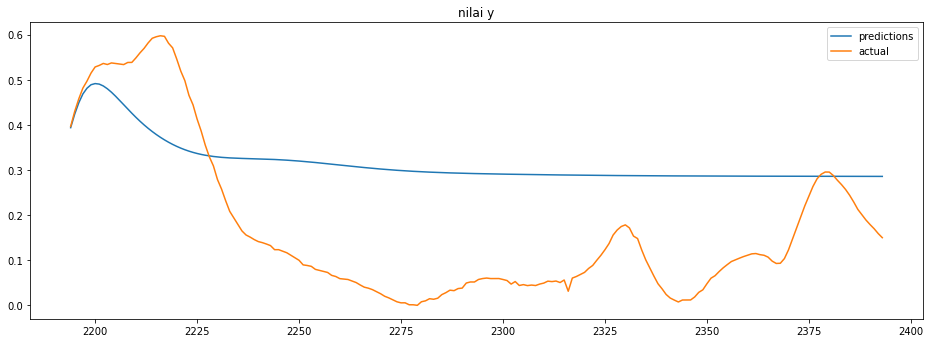

In [19]:
from matplotlib.pyplot import figure
plt.figure(1)
plt.subplot(211)
y_pred.plot(figsize = (16,12), label ="predictions")
y__actual.plot(figsize = (16,12), label = "actual")
plt.legend(fontsize=10)
plt.title('nilai y')